# real_shape_optimization

> Fix isogonal modes and get real space vertices by minimizing metric energy under (soft?) tension constraint.

Unfortunately, our shape-based energy turns out to be quite _brittle_ and prone to issues like self-intersection etc

# to do:

- plotting function to color cells, or triangles by `dict`

In [ ]:
#| default_exp isogonal

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

from math import floor, ceil

import sys

from copy import deepcopy

from collections import Counter

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc
rc('animation', html='html5')

In [ ]:
#| export

import autograd.numpy as anp  # Thinly-wrapped numpy
from autograd import grad as agrad

In [ ]:
#| notest

# reimport stuff if required after updating the code elsewhere

import importlib

## this is how you re-import a module
#importlib.reload(nameOfModule)

## this is how you reload a specific function or class
#import X
#reload(X)
#from X import Y  # or * for that matter

## matplotlib slider plots

Structure: create a _callback function_ which does the plotting you want, depending on parameter. Then use generator, e.g. `widgets.interact` with a slider for each argument, to create user interfaces.

For optimization, one can rewrite the callback function to do as little as possible, e.g. by re-using the figure created. Ignore for now...

Plotting different times can be done easily this way by passing index to data array as callback argument


https://notebook.community/seewhydee/ntuphys_nb/jupyter_tutorial/jupyter_tutorial_02

Other slides types exist also, eg. `IntSlider`, or `ToggleButton`. See https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html. You can also write a somewhat optimized function, where minimal amount of work is done in the callback function, and the figure is only created once.

#### Animation

we can also done HMTL5 animations in place. This is nice, I don't have to jump to terminal to render with fffmpeg.

## Definition of the cell shape tensor, and vertex model energy

Now based off of the sides

In [ ]:
#| export

@patch
def get_shape_tensor(self: Face):
    neighbors = [he.twin.face for he in self.hes]
    if (None in neighbors) or self is None:
        return np.eye(2)
    edges = np.stack([x.dual_coords-self.dual_coords for x in neighbors])
    lengths = np.linalg.norm(edges, axis=-1)
    return 2*np.einsum('ei,ej->ij', edges, (edges.T/(lengths.T+1e-3)).T)

@patch
def set_rest_shapes(self: HalfEdgeMesh):
    """ill defined for boundary faces."""
    for fc in self.faces.values():
        if fc is not None:
            fc.rest_shape = fc.get_shape_tensor()

In [ ]:
#| export

@patch
def get_shape_tensor(self: Vertex):
    neighbors = self.get_face_neighbors()
    if (None in neighbors) or self is None:
        return np.eye(2)
    cell = np.stack([fc.dual_coords for fc in neighbors])
    edges = cell - anp.roll(cell, 1, axis=0)
    lengths = np.linalg.norm(edges, axis=-1)+1e-5
    units = (edges.T/lengths.T).T
    return np.einsum('ei,ej->ij', edges, units)

In [ ]:
#| export

@patch
def get_stress_tensor(self: Face):
    verts = np.stack([he.vertices[0].coords for he in self.hes])
    edges = verts - np.roll(verts, 1, axis=0)
    edges = np.stack([-edges[:,1], edges[:,0]])
    return 2/3*np.einsum('ie,je->ij', edges, edges)

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)
mesh.set_voronoi()
mesh.faces[1].get_shape_tensor(), sqrt(3)

(array([[1.72905599e+00, 5.55111512e-17],
        [1.66533454e-16, 1.72905599e+00]]),
 1.7320508075688772)

In [ ]:
mesh.vertices[9].get_shape_tensor()

array([[1.73202081, 0.        ],
       [0.        , 1.73202081]])

In [ ]:
#| export

def polygon_area(pts):
    """area of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(pts[:,0]*anp.roll(pts[:,1], 1, axis=0) - anp.roll(pts[:,0], 1, axis=0)*pts[:,1], axis=0)/2

def polygon_perimeter(pts):
    """perimeter of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(anp.linalg.norm(pts-anp.roll(pts, 1, axis=0), axis=1), axis=0)

def get_vertex_energy(pts, A0=1, P0=1, mod_shear=0, mod_bulk=1):
    """Get vertex style energy"""
    return mod_bulk*(polygon_area(pts)-A0)**2 + mod_shear*(polygon_perimeter(pts)-P0)**2

@patch
def get_area(self: Vertex):
    neighbors = [fc for fc in self.get_face_neighbors()]
    if None in neighbors:
        return None
    return polygon_area(np.stack([fc.dual_coords for fc in neighbors]))

In [ ]:
#| export

@patch
def get_shape_energy(self: HalfEdgeMesh, mod_shear=.1, mod_bulk=1, mod_area=0, A0=np.sqrt(3)/2):
    res_dict = {}
    for v in self.vertices.values():
        if None in v.get_face_neighbors():
            res_dict[v._vid] = None
        else:
            delta = v.get_shape_tensor()-v.rest_shape
            E_shape = mod_shear*(delta**2).sum()+mod_bulk*np.trace(delta)**2
            E_area = mod_area * (v.get_area()-A0)**2
            res_dict[v._vid] = E_shape+E_area
    return res_dict

NameError: name 'patch' is not defined

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)
mesh.set_voronoi()
mesh.vertices[14].get_area()

0.8660254037844386

In [ ]:
poly = np.array([[-0.45, -0.31],
           [-0.54,  0.36],
           [ 0.09,  0.61],
           [ 0.54,  0.22],
           [ 0.51, -0.37],
           [ 0.07, -0.61]])

poly_repeat = poly = np.array([[-0.45, -0.31],
           [-0.54,  0.36],
           [ 0.09,  0.61],
           [ 0.54,  0.22],
           [ 0.51, -0.37],
           [ 0.07, -0.61], [ 0.07, -0.61], [ 0.07, -0.61]])


In [ ]:
poly_stacked = np.stack(50*[poly_repeat], axis=-1)

In [ ]:
polygon_area(poly_stacked)

array([0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471])

In [ ]:
polygon_perimeter(poly_stacked)

array([3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853,
       3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853,
       3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853,
       3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853,
       3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853,
       3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853,
       3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853,
       3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853, 3.6415853,
       3.6415853, 3.6415853])

In [ ]:
polygon_area(poly), polygon_area(poly_repeat)

(0.9471, 0.9471)

## Code for primal energy minimization

Need to ``serialize'' half edge mesh for rapid optimization

In [ ]:
#| export

@patch
def dual_vertices_to_initial_cond(self: HalfEdgeMesh):
    """Format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    dual_vertex_vector = np.stack([self.faces[key].dual_coords for key in face_keys]).T
    return np.hstack([dual_vertex_vector[0], dual_vertex_vector[1]])
       
@patch
def initial_cond_to_dual_vertices(self: HalfEdgeMesh, x0):
    """Reverse of format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
    dual_vertex_vector = np.stack([x, y], axis=1)
    return {key: val for key, val in zip(face_keys, dual_vertex_vector)}


### Angle constraint energy

In [ ]:
#| export

@patch
def get_angle_deviation(self: HalfEdgeMesh):
    """Sin(angle) between primal and dual edges. For diagnostics"""
    angle_deviation = {}

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None):
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            primal_edge = he.face.dual_coords - he.twin.face.dual_coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = primal_edge / np.linalg.norm(primal_edge)        
            angle_deviation[he._heid] = np.abs(np.dot(dual_edge, primal_edge))
    return angle_deviation

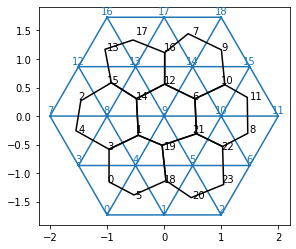

In [ ]:
# iterate over edges and ensure angle primal | dual = 0

mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.05))

mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
sum(mesh.get_angle_deviation().values()) / 2

2.3998792170990173

## Energy function

In [ ]:
#| export

@patch
def get_primal_energy_fct_cells(self: HalfEdgeMesh, mod_bulk=1, mod_shear=.01, angle_penalty=100,
                                reg_bulk=0, A0=sqrt(3)/2, epsilon_l=1e-5):
    """Get function to compute primal energy from primal vertices. Cell based shape tensor"""

    # book-keeping
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    n_faces = len(self.faces)

    # stuff for the shape tensor energy
    cell_list = []
    rest_shapes = []
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            cell = [face_key_dict[fc._fid] for fc in neighbors]
            cell_list.append(cell)
            rest_shapes.append(v.rest_shape)
    valences = [len(cell) for cell in cell_list]
    max_valence = max(valences)
    valence_mask = anp.array([x*[0,]+(max_valence-x)*[1,] for x in valences])
    cell_list = anp.array([anp.pad(cell, (0, max_valence-len(cell)), mode="edge") for cell in cell_list])
    rest_shapes = anp.stack(rest_shapes)

    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            # rotate by 90 degrees
            dual_edge = anp.array([dual_edge[1], -dual_edge[0]])
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]] # 0= he, 1= twin
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)
    
    # breaking translational invariance.
    center = anp.mean([v.coords for v in self.vertices.values()], axis=0)
    
    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        # face-based shape energy
        cells = anp.stack([[x[i], y[i]] for i in cell_list.T], axis=-1).T
        edges = cells - anp.roll(cells, 1, axis=0)
        lengths = anp.linalg.norm((edges.T + valence_mask).T, axis=-1) + 10*epsilon_l
        # stupid hack to avoid 0-division error due to padding in the jacobian
        units = (edges.T/lengths.T).T
        tensors = anp.einsum('efi,efj->fij', edges, units) - rest_shapes
        E_shape = (mod_shear*4*anp.mean(tensors**2)
                   + mod_bulk*anp.mean((tensors[:,0,0]+tensors[:,1,1])**2))
        # regularize with the vertex model energy
        if reg_bulk > 0:
            E_vertex = reg_bulk*anp.mean((polygon_area(cells)-A0)**2)
        else:
            E_vertex = 0
        # angle penalty
        pts = anp.stack([x, y], axis=-1)
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]] # he.twin.face-he.face
        lengths = anp.linalg.norm(e_primal, axis=-1) 
        # + epsilon to avoid 0-division error and make penalty smooth as length passes through 0
        # makes energy barrier so need epsilon small!
        penalty = (1-anp.einsum('ei,ei->e', e_primal, e_dual)/(lengths+epsilon_l))
        E_angle = angle_penalty * anp.mean(penalty) 
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        
        return  E_angle + E_shape + E_vertex + E_trans
    
    return get_E, agrad(get_E)

## Minimization, angle constrained 

Big speed improvement obtained by vectorizing the cell-area vertex model term. Optimization works best with method BFGS, can put a cap on max iterations. Sometimes, optimizer complains about precision loss but that seems to be ok.

Creation of the energy function and re-setting of positions is pretty fast, 10ms each approx for 13*9 mesh.

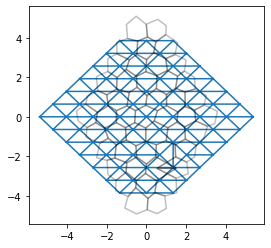

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=13, nx=9)

mesh.flip_edge(151)  # this creates an example of an edge with != 6 sides. e.g. 9
mesh.set_voronoi()
mesh.set_rest_lengths()

for fc in mesh.faces.values():
    fc.rest_shape = sqrt(3)*np.eye(2)
for v in mesh.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.06))
mesh.transform_vertices(shear_mat(1.35))

mesh.cellplot(alpha=.25)
mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
mod_bulk = 1
mod_shear = 0.1

# if the shear modulus is too low, a very high precision is needed in the optimizer to get the "right" solution
# this is because the bulk energy is much lower than the shear energy, so the tol option works differently
# taking the log of all energies makes them very similar and leads to more similar results for different
# values of the shear modulus when keeping tol fixed

angle_penalty = 100

A0 = sqrt(3)/2
reg_bulk = 0

epsilon_l = 1e-5

cell_shape_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear, "angle_penalty": angle_penalty,
                   "A0": A0, "reg_bulk": reg_bulk, "epsilon_l": epsilon_l,} 

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
get_E, jac = mesh.get_primal_energy_fct_vertices(**cell_shape_args)

In [ ]:
_ = jac(x0)
get_E(x0)

5.232886548094027

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", tol=.5*1e-2, options={"maxiter": 500})
print(sol["message"])
print(get_E(x0)/get_E(sol["x"]))

# tol = 1e-1 -> energy =.25, .8s. this is not good enough!
# tol = 5*1e-2 -> energy =.05, 3s with maxiter 250
# might be better to set max iter. to around 200
# 

Optimization terminated successfully.
491.0043387614156
CPU times: user 2.49 s, sys: 1.26 s, total: 3.75 s
Wall time: 1 s


In [ ]:
new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh.faces.items():
    val.dual_coords = new_coord_dict[key]

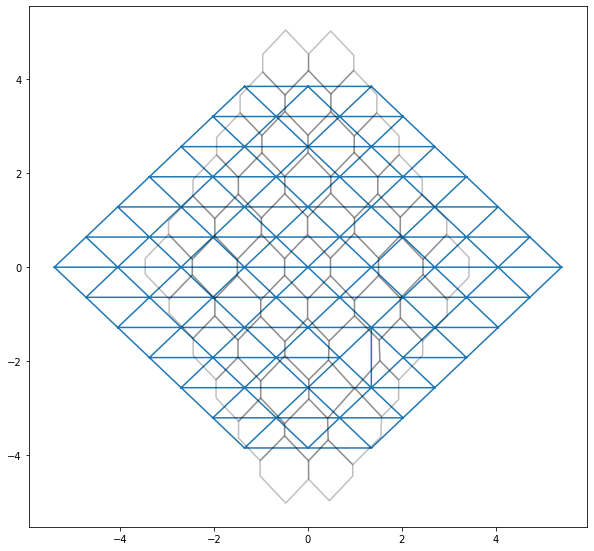

In [ ]:
# completely correct - but can have problem at boundary if there was an edge flip!
# in this case, ever self-intersection can occur.

# actually it already does here!

fig = plt.figure(figsize=(10, 10))

mesh.cellplot(alpha=.25)
mesh.triplot()
#mesh.labelplot() # halfedge_labels=True

#pts = np.stack([fc.dual_coords for fc in mesh.vertices[10].get_face_neighbors()])
#plt.scatter(*pts.T, c="r")

plt.gca().set_aspect("equal", adjustable="box");

How do the different terms in the energy compare?

### We will need to compute primal lengths to flip edges

Might use the same technique as above to get the line orientation right (i.e. check whether parallel or anti-parallel with the centroid connector), which might be better numerically.

Indexed by `_heid`

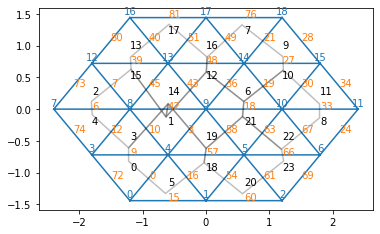

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_rest_lengths() 
mesh.transform_vertices(shear_mat(1.2)) # 1.31almost 90 degree angles
mesh.set_voronoi()
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.02))

# create self-intersection
mesh.faces[14].dual_coords, mesh.faces[1].dual_coords = (mesh.faces[1].dual_coords, mesh.faces[14].dual_coords)


mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot(halfedge_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
#| export

@patch
def get_primal_edge_lens(self: HalfEdgeMesh, oriented=True):
    len_dict = {}
    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            primal_vec = he.face.dual_coords-he.twin.face.dual_coords
            length = np.linalg.norm(primal_vec)
            if oriented:
                centroid_vec = (np.mean([x.vertices[0].coords for x in he.face.hes], axis=0)
                                -np.mean([x.vertices[0].coords for x in he.twin.face.hes], axis=0))
                length *= np.sign(np.dot(primal_vec, centroid_vec))
            len_dict[he._heid] = length
    return len_dict

In [ ]:
primal_lengths = mesh.get_primal_edge_lens(oriented=True)
argmin = min(primal_lengths, key=primal_lengths.get)
argmin, primal_lengths[argmin]

(42, -0.211291276276291)

## Code to detect problematic primal mesh configurations

Write some code for automatic detection of problems in primal vertex positions:
- Any real-space angles > 180 degrees = non-convex polygons
- Any vertices lying inside other polygons
- Any self-intersecting polygons

In [ ]:
#| export

def is_convex_polygon(polygon):
    """Return True if the polynomial defined by the sequence of 2D
    points is 'strictly convex': points are valid, side lengths non-
    zero, interior angles are strictly between zero and a straight
    angle, and the polygon does not intersect itself.

    NOTES:  1.  Algorithm: the signed changes of the direction angles
                from one side to the next side must be all positive or
                all negative, and their sum must equal plus-or-minus
                one full turn (2 pi radians). Also check for too few,
                invalid, or repeated points.
            2.  No check is explicitly done for zero internal angles
                (180 degree direction-change angle) as this is covered
                in other ways, including the `n < 3` check.
    Source: stackoverflow.com/questions/471962/how-do-i-efficiently-determine-if-a-polygon-is\
    -convex-non-convex-or-complex
    """
    try:  # needed for any bad points or direction changes
        # Check for too few points
        if polygon.shape[0] < 3:
            return False
        # Get starting information
        old_x, old_y = polygon[-2]
        new_x, new_y = polygon[-1]
        new_direction = np.arctan2(new_y - old_y, new_x - old_x)
        angle_sum = 0.0
        # Check each point (the side ending there, its angle) and accum. angles
        for ndx, newpoint in enumerate(polygon):
            # Update point coordinates and side directions, check side length
            old_x, old_y, old_direction = new_x, new_y, new_direction
            new_x, new_y = newpoint
            new_direction = np.arctan2(new_y - old_y, new_x - old_x)
            if old_x == new_x and old_y == new_y:
                return False  # repeated consecutive points
            # Calculate & check the normalized direction-change angle
            angle = new_direction - old_direction
            if angle <= -pi:
                angle += 2*pi  # make it in half-open interval (-Pi, Pi]
            elif angle > pi:
                angle -= 2*pi
            if ndx == 0:  # if first time through loop, initialize orientation
                if angle == 0.0:
                    return False
                orientation = 1.0 if angle > 0.0 else -1.0
            else:  # if other time through loop, check orientation is stable
                if orientation * angle <= 0.0:  # not both pos. or both neg.
                    return False
            # Accumulate the direction-change angle
            angle_sum += angle
        # Check that the total number of full turns is plus-or-minus 1
        return abs(round(angle_sum / (2*pi))) == 1
    except (ArithmeticError, TypeError, ValueError):
        return False  # any exception means not a proper convex polygon

In [ ]:
#| export

@patch
def find_primal_problematic(self: HalfEdgeMesh):
    """Identify problematic cells and edges"""
    bad_edges = [key for key, val in self.get_primal_edge_lens(oriented=True).items() if val <0]
    bad_cells = []
    for v in self.vertices.values():
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            if not is_convex_polygon(np.stack([fc.dual_coords for fc in neighbors])):
                bad_cells.append(v._vid)
    return bad_cells, bad_edges

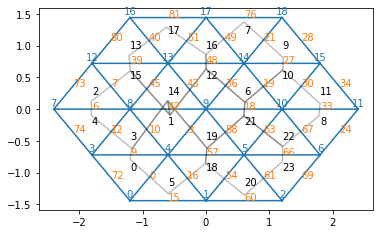

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_rest_lengths() 
mesh.transform_vertices(shear_mat(1.2)) # 1.31almost 90 degree angles
mesh.set_voronoi()
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.02))

# create self-intersection
mesh.faces[14].dual_coords, mesh.faces[1].dual_coords = (mesh.faces[1].dual_coords, mesh.faces[14].dual_coords)


mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot(halfedge_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
mesh.find_primal_problematic()

([8, 9], [42])

### Various helper functions for the iteration over time steps

Just to make things more compact

In [ ]:
#| export

# for re-setting primal vertex positions after intercalation
def rotate_about_center(x, angle=pi/2):
    """Rotate pts about center. x.shape = (n_pts, 2)"""
    center = np.mean(x, axis=0)
    return (x-center)@rot_mat(angle)+np.mean(x, axis=0)

In [ ]:
#| export

@patch
def optimize_cell_shape(self: HalfEdgeMesh, energy_fct_kwargs=None, tol=1e-3, maxiter=250, verbose=True):
    """primal optimization"""
    energy_fct_kwargs = dict() if energy_fct_kwargs is None else energy_fct_kwargs
    get_E, jac = self.get_primal_energy_fct_vertices(**energy_fct_kwargs)
    x0 = self.dual_vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", tol=tol, options={"maxiter": maxiter})
    if sol["status"] !=0 and verbose:
        print("Cell shape optimization failed", sol["message"])
    new_coord_dict = self.initial_cond_to_dual_vertices(sol["x"])
    for key, val in self.faces.items():
        val.dual_coords = new_coord_dict[key]

## Full simulation, as example

### notes:

- not too bad using non-metric non-oriented edges! Eventually still develops some self-intersection.

-> try regularizing using vertex energy! Works well. Problem is really the boundary. Might use stronger regularization there.

Profiling: even after vectorization, the majority of time is spent on the cell shape optimization, approx 10x longer than on triangulation flattening. For a 13x19 mesh, need 5mins for simulation.

When the cell shape optimization can fail (precision loss): This happens when lengths are very short, and is due to the shear modulus. lower shear modulus is better. problem not very harmful. none of the attempts to remove it were successful.

In [ ]:
# set parameters. 

m = 4 # larger than 4 seems to lead to trouble
k = 1 # tried 1


dt = .0025 #0.005
n_steps = 5  # for testing purposes

minimal_l = .1

mod_bulk = 1
mod_shear = 0.1
angle_penalty = 1000

epsilon_l = 1e-6
# necessary or we get precision loss error in optimizer.

A0 = sqrt(3)/2
reg_bulk = 0

rest_shape = sqrt(3)*np.eye(2)

forbid_reflip = 40 # do not re-flip an edge flipped in the last $n timesteps

tol, maxiter = (1e-4, 1000) # note: iteration limit can depend on mesh size! larger mesh = more iterations

cell_shape_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear, "angle_penalty": angle_penalty,
                   "A0": A0, "reg_bulk": reg_bulk, "epsilon_l": epsilon_l}

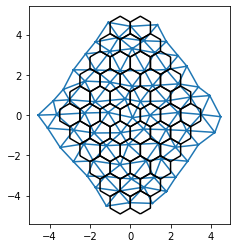

In [ ]:
mesh = get_tri_hemesh(noise=0, nx=9, ny=13)  # 13, 19
mesh.set_voronoi()
for fc in mesh.faces.values():
    fc.rest_shape = sqrt(3)*np.eye(2)
mesh.transform_vertices(lambda x: shear_mat(1.15)@x+np.random.normal(size=2, scale=0.1))
#0.01 basically equivalent to no noise. 0.025 too
mesh.set_rest_lengths()

mesh.cellplot()
mesh.triplot()
plt.gca().set_aspect("equal", adjustable="box")

In [ ]:
## simulate

meshes = []
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

for i in tqdm(range(n_steps)):    
    # euler step
    mesh.euler_step(dt=dt, rhs=excitable_dt_post, params={"k": k, "m": m})
    # flatten triangulation
    mesh.flatten_triangulation()
    # primal optimization
    mesh.optimize_cell_shape(energy_fct_kwargs=cell_shape_args, tol=tol, maxiter=maxiter, verbose=True)
    # alternative - set voronoi. is this much different??
    #mesh.set_voronoi()
    
    # check for intercalation
    primal_lengths = mesh.get_primal_edge_lens(oriented=True)
    flipped = []
    for key, val in primal_lengths.items():
        if val < minimal_l and not any([key in x for x in last_flipped_edges[-forbid_reflip:]]):  
            try:
                print(f"flip {key}, tpt {i}")
                he = mesh.hes[key]
                mesh.flip_edge(key)
                mesh.reset_rest_passive_flip(he, method="smooth") # smooth
                f0, f1 = (he.face, he.twin.face)
                f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords, f1.dual_coords]))
                flipped.append(he._heid)
            except ValueError:
                continue
    if flipped:
        mesh.optimize_cell_shape(energy_fct_kwargs=cell_shape_args, tol=tol, maxiter=maxiter, verbose=True)
    # re-center
    center = anp.median([v.coords for v in mesh.vertices.values()], axis=0)
    mesh.transform_vertices(lambda x: x-center)
    center = anp.median([fc.dual_coords for fc in mesh.faces.values()], axis=0)
    mesh.transform_dual_vertices(lambda x: x-center)
    
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

last_flipped_edges = last_flipped_edges[1:]
times = np.array(times)[1:]

# 30s if no area reg is used. 46s if non-zero area reg is used
# 1h30min for 19*29

  0%|          | 0/5 [00:00<?, ?it/s]

flip 243, tpt 0
flip 147, tpt 0
flip 99, tpt 3
flip 93, tpt 4


In [ ]:
moments = np.stack([get_inertia(np.stack([fc.dual_coords for fc in msh.faces.values() if not fc.is_bdr()]))
                    for msh in meshes])
T1_count = np.cumsum([len(x) for x in last_flipped_edges])
stresses = np.stack([np.mean([fc.get_stress_tensor() for fc in msh.faces.values()], axis=0) for msh in meshes])

Text(0, 0.5, 'T1 count/Delaunay vertex')

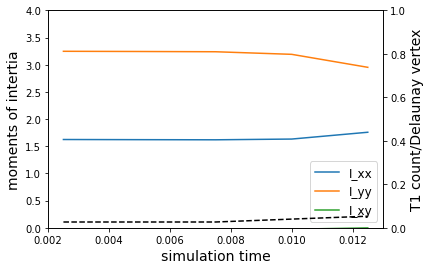

In [ ]:
plt.plot(times, moments[:,0,0], label="I_xx")
plt.plot(times, moments[:,1,1], label="I_yy")
plt.plot(times, moments[:,0,1], label="I_xy")
plt.ylim([0, 4])

plt.xlabel("simulation time", fontsize=14)
plt.ylabel("moments of intertia", fontsize=14)
plt.legend(fontsize=12, loc='lower right')

plt.gca().twinx().plot(times, np.array(T1_count)/len(mesh.vertices.values()), color="k", ls="dashed")
plt.ylim([0, 1])
plt.ylabel("T1 count/Delaunay vertex", fontsize=14)

# the amount of noise that can kill extension might depend on the size?
# try al

[<matplotlib.lines.Line2D>]

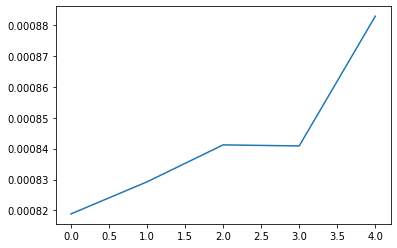

In [ ]:
plt.plot([np.mean(list(msh.get_angle_deviation().values())) for msh in meshes])
# voronoi. spikes in mean are due to T1's. so use median

<matplotlib.collections.LineCollection>

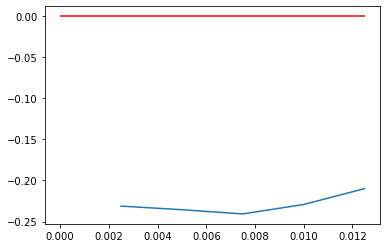

In [ ]:
plt.plot(times, (stresses[:,0,0]-stresses[:,1,1])/(stresses[:,0,0]+stresses[:,1,1]),
         label="deviatoric")
plt.hlines(0, 0, times[-1], color="r")

<matplotlib.legend.Legend>

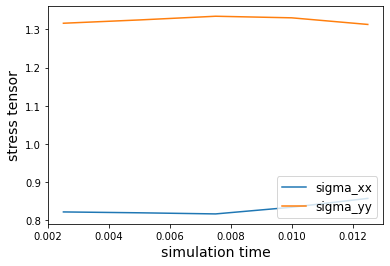

In [ ]:
plt.plot(times, stresses[:,0,0], label="sigma_xx")
plt.plot(times, stresses[:,1,1], label="sigma_yy")
#plt.plot(times, stresses[:,0,1], label="sigma_xy")

plt.xlabel("simulation time", fontsize=14)
plt.ylabel("stress tensor", fontsize=14)
plt.legend(fontsize=12, loc='lower right')


[<matplotlib.lines.Line2D>]

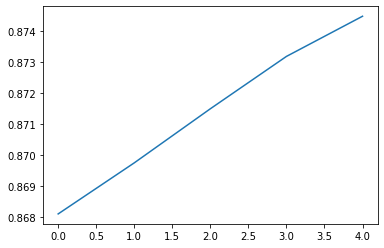

In [ ]:
plt.plot([meshes[t].hes[41].rest for t in range(len(meshes))])

# sometimes, one can get an _increase_ in tension after a flip! that is pretty strange, but possible.

In [ ]:
# create a time-series of areas

areas = np.empty((len(meshes), len(meshes[0].vertices)))
for t, msh in enumerate(meshes):
    for v in msh.vertices.values():
        nghbs = v.get_face_neighbors()
        if (None in nghbs):
            areas[t, v._vid] = np.nan
        else: 
            areas[t, v._vid] = polygon_area(np.stack([fc.dual_coords for fc in nghbs]))
            
areas = areas[:, ~np.isnan(areas).any(axis=0)]
areas.shape

(5, 47)

(0.0, 1.7320508075688772)

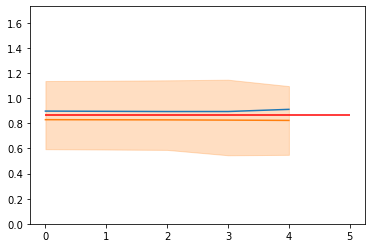

In [ ]:
plt.plot(areas[:, 40])
mean = areas.mean(axis=1)

plt.plot(mean)
plt.fill_between(np.arange(areas.shape[0]), np.quantile(areas, .05, axis=1),
                 np.quantile(areas, .95, axis=1),
                 color="tab:orange", alpha=.25)

plt.hlines(A0, 0, len(meshes), color="r")
plt.ylim([0, sqrt(3)])

# one more possibility: set the A0 anew for each cell, at each iteration. this cannot prevent drift, ofc.


<IPython.core.display.Javascript object>


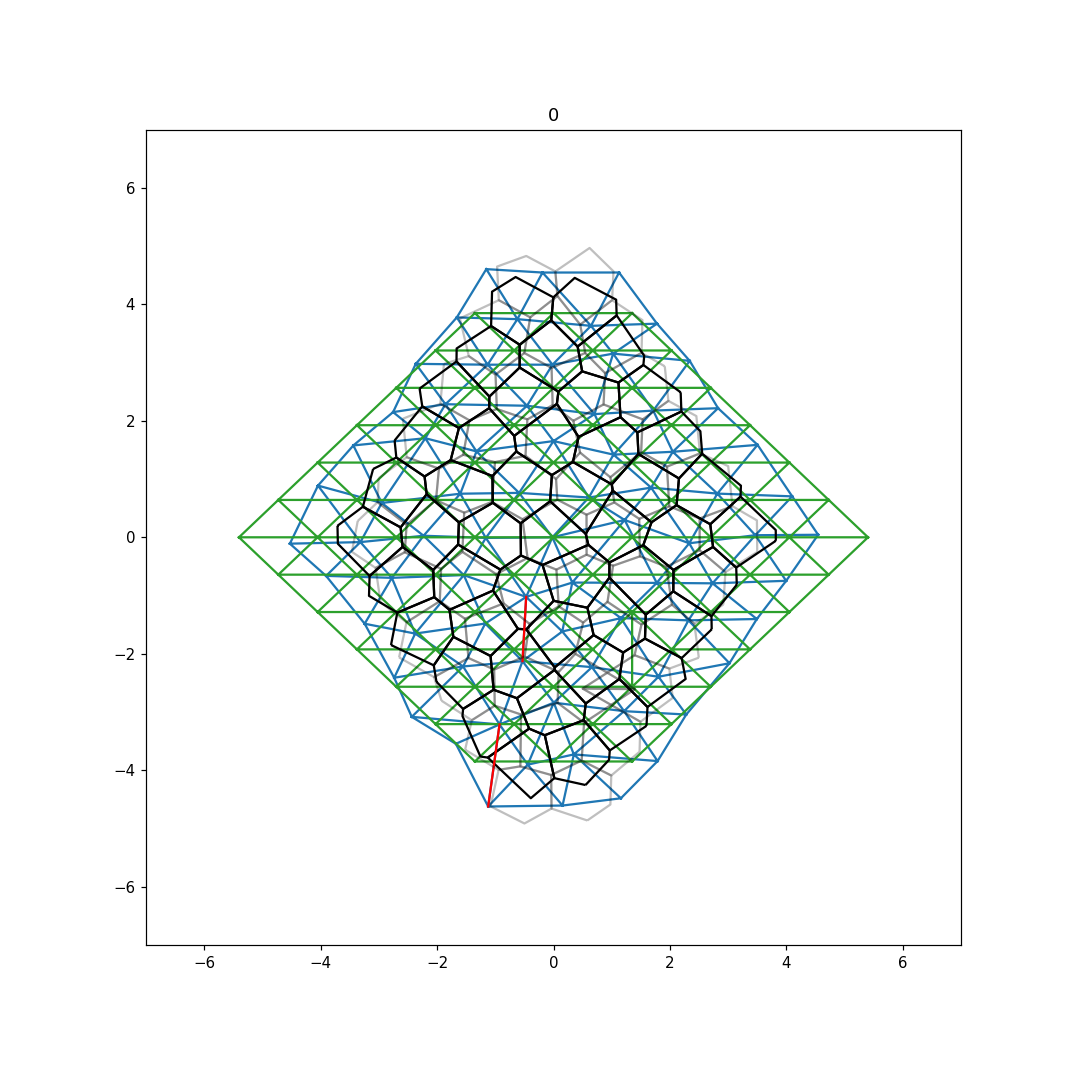

interactive(children=(IntSlider(value=29, description='i', max=58), Output()), _dom_classes=('widget-interact'…

In [ ]:
#| notest
%matplotlib notebook

# Plotting function for slider plot
# using the notebook plot mode gives smoother results. still not completely optimize but whatever
#

fig = plt.figure(figsize=(10, 10))
def plot_mesh(i):
    plt.cla()
    plt.xlim([-7, 7])
    plt.ylim([-7, 7])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot()
    meshes[i].triplot()
    plt.title(i)
    for x in last_flipped_edges[i]:
        he = meshes[i].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        plt.plot(*line.T, c="r")
widgets.interact(plot_mesh, i=(0, n_steps-2, 1));

In [ ]:
#| notest
%matplotlib inline

## Now let's also save it als HTML5 animation - can take a bit of time due to inefficiency

# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300)
# animation parameters
nframes, frame_dt = n_steps, 200  # Delay between frames in milliseconds

# function that draws each frame of the animation
def animate_meshes(n):
    plt.cla()
    plt.xlim([-12, 12])
    plt.ylim([-12, 12])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title('.')
    meshes[n].cellplot()
    meshes[n].triplot()
    #for x in last_flipped_edges[i]:
    #    he = meshes[i].hes[x]
    #    line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
    #    plt.plot(*line.T, c="r")
    if n == nframes-1:
        plt.close()

# run the animation
anim = animation.FuncAnimation(fig, animate_meshes, frames=nframes, interval=frame_dt, repeat=False)
anim.save('plots/large_patch.mp4', fps=4,)
#extra_args=['-vcodec', 'libx264'])

## Deprecated code

In [ ]:
#| notest

@patch
def get_primal_energy_fct_vertices(self: HalfEdgeMesh, mod_bulk=1, mod_shear=.01, angle_penalty=100,
                                   reg_bulk=0, A0=sqrt(3)/2, epsilon_l=1e-5):
    """Get function to compute primal energy from primal vertices. Vertex-based shape tensor"""

    # stuff for the shape tensor energy
    face_list = []    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    face_key_dict[None] = None
    rest_shapes = []
    for fc in self.faces.values():
        neighbors = [he.twin.face for he in fc.hes]
        if not (None in neighbors):
            face_list.append(anp.array([face_key_dict[x._fid] for x in neighbors]
                                      +[face_key_dict[fc._fid]]))
            rest_shapes.append(fc.rest_shape)
    face_list = anp.array(face_list).T
    rest_shapes = anp.stack(rest_shapes)
    n_faces = len(self.faces)

    # stuff for the vertex-energy-based regularization
    if reg_bulk>0:
        cell_list = []
        for v in self.vertices.values():    # iterate around vertex.
            neighbors = v.get_face_neighbors()
            if not (None in neighbors):
                cell = [face_key_dict[fc._fid] for fc in neighbors]
                cell_list.append(cell)
        max_valence = max([len(cell) for cell in cell_list])
        cell_list = anp.array([anp.pad(cell, (0, max_valence-len(cell)), mode="edge") for cell in cell_list])
    
    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            # rotate by 90 degrees
            dual_edge = anp.array([dual_edge[1], -dual_edge[0]])
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]] # 0= he, 1= twin
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)
    
    # breaking translational invariance.
    center = anp.mean([v.coords for v in self.vertices.values()], axis=0)
    
    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        pts = anp.stack([x, y], axis=-1)
        # shape energy
        edges = anp.stack([pts[a]-pts[face_list[3]] for a in face_list[:3]])
        lengths = anp.linalg.norm(edges, axis=-1) + 10*epsilon_l # + epsilon to avoid 0-division error
        units = (edges.T/lengths.T).T        
        tensors = 2*anp.einsum('efi,efj->fij', edges, units) - rest_shapes
        E_shape = (mod_shear*4*anp.mean(tensors**2)
                   + mod_bulk*anp.mean((tensors[:,0,0]+tensors[:,1,1])**2))
        # regularize with the vertex model energy
        if reg_bulk > 0:
            poly = anp.stack([[x[i], y[i]] for i in cell_list.T]) # shape (max_valence, 2, n_cells)
            E_vertex = reg_bulk*anp.mean((polygon_area(poly)-A0)**2)
        else:
            E_vertex = 0
        # angle penalty
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]] # he.twin.face-he.face
        lengths = anp.linalg.norm(e_primal, axis=-1) 
        # + epsilon to avoid 0-division error and make penalty smooth as length passes through 0
        # makes energy barrier so need epsilon small!
        penalty = (1-anp.einsum('ei,ei->e', e_primal, e_dual)/(lengths+epsilon_l))
        E_angle = angle_penalty * anp.mean(penalty) 
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        
        return  E_angle + E_shape + E_vertex + E_trans
    
    return get_E, agrad(get_E)